CFE Data Assimilation of USGS streamflow data. Real Data Example

In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta
sys.path.insert(0, './CFE')
import bmi_cfe_originial
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

In [2]:
## Open BMI's for each file
cfe_open = bmi_cfe_originial.BMI_CFE()
#cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars


enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [3]:
## Initialize the BMI's
# Fake forcing data
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_modell.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json') # I am confused what this config file should look like


# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')


# 2016 and 2017 Case Study 
# cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')
# cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration_16_17.json')

# enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config_16_17.json')


initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


              time  APCP_surface  RAINRATE      T2D       Q2D     U2D     V2D  \
0     5/15/17 0:00           0.0       0.0  284.078  0.006616  6.0804 -1.9670   
1     5/15/17 1:00           0.0       0.0  283.180  0.006650  6.0304 -2.0740   
2     5/15/17 2:00           0.0       0.0  282.440  0.006614  5.9856 -2.1828   
3     5/15/17 3:00           0.0       0.0  281.662  0.006476  5.9402 -2.2888   
4     5/15/17 4:00           0.0       0.0  281.702  0.006530  6.3688 -2.5458   
..             ...           ...       ...      ...       ...     ...     ...   
763  6/15/17 19:00           0.0       0.0  295.270  0.007334 -1.1600  4.5018   
764  6/15/17 20:00           0.0       0.0  294.610  0.006788 -1.2230  4.4990   
765  6/15/17 21:00           0.0       0.0  293.624  0.006776 -1.2812  4.4996   
766  6/15/17 22:00           0.0       0.0  292.722  0.006714 -1.5682  3.8524   
767  6/15/17 23:00           0.0       0.0  291.554  0.006650 -1.8486  3.1996   

          PSFC   SWDOWN   L

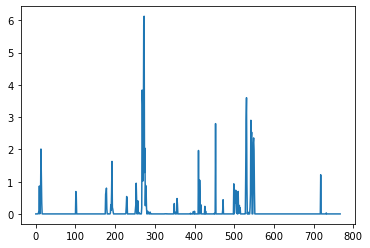

In [4]:
## Look at forcing data if interested
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

Final Framework for running each CFE model, EnKF DA, and USGS. 

In [5]:
#Make empty matrices for plotting
cfeOpen     = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF     = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): 
    
    # Set values for each CFE model. Adding precipitation since we are using an uncalibrated model to see flow result
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) # Need array for EnKf function. Should get this when initialize CFS 
    
    # Check validity when there is missing data
    validity = usgs.get_value('validity')[i]
    print("-------------------------------------------------")
    print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variable originial values from CFE Peturbed to update in EnKF
    soil_storage_avail             = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    storage_max_m                  = cfe_peturbed.get_value("storage_max_out_m")
    surface_runoff                 = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    
    # Set outflow for CFE Open and CFE Peturbed to plot
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
   
    # Get mean and covariance of CFE Peturbed outflor of ensemble runs for EnKF
    outflow_peturb       = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    outflow_peturb_mean  = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting

    # Set EnKF state variable values to state variables from CFE Petubred
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) 
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) 
    enkf.set_value('surface_runoff_depth_m', surface_runoff)
    enkf.set_value('storage_max_m',storage_max_m)
    
    # Set EnkF values usgs, mean, and covariance (from CFE Peturbed)
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    #enkf_validity=enkf.set_value('validity',validity) #check validity if needed
    enkf.update()

    # For plotting if needed
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)
    
    # Get updated state variable values from EnKF to pass into CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

    # Set CFE analysis state variable changes from EnKF to get final true streamflow values
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) 
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # For plotting CFE Analysis from newly updated state variables. FINAL MODEL! 
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 
        
    # Get CFE Analysis state variables to then pass back into CFE Peturbed 
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    # Set updated state variables into CFE Peturbed for the loop of updating state variables to continue! 
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
# Finalize the models! 
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [111.47243876]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.34684391011893256
EnKF Code predicted, X Post [112.7747644]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.35351173569984606
EnKF Code predicted, X Post [85.43350748]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3599842217027115
EnKF Code predicted, X Post [114.42908768]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginnin

EnKF Code predicted, X Post [71.88613621]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.4694729361261929
EnKF Code predicted, X Post [73.71225222]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.472548240891134
EnKF Code predicted, X Post [78.62515123]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.47553345200742414
EnKF Code predicted, X Post [84.3283663]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.4784312088445397
EnKF Code predicted, X Post [86.43505797]
 warning validity is zero
---------

EnKF Code predicted, X Post [37.31825883]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.507972833851125
EnKF Code predicted, X Post [36.94682157]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5099202516182404
EnKF Code predicted, X Post [35.46643069]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5118106181382445
EnKF Code predicted, X Post [36.04485723]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5136456047755728
EnKF Code predicted, X Post [31.88523693]
 warning validity is zero
---------

EnKF Code predicted, X Post [41.71570552]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.13445028366078804
EnKF Code predicted, X Post [40.79906823]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.1473403597893458
EnKF Code predicted, X Post [40.22538539]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.15985281025847298
EnKF Code predicted, X Post [40.27948195]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.17199869793057943
EnKF Code predicted, X Post [40.04711487]
 warning validity is zero
-----

EnKF Code predicted, X Post [83.48524596]
 warning validity is zero
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.36769446047620746
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.37375145158650747
EnKF Code predicted, X Post [81.4764628]
 warning validity is zero
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.37963099803012135
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3853382981983231
EnKF Code predicted, X Post [79.76716735]
 warning validity is zero
----------------------

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.4415412440466522
EnKF Code predicted, X Post [68.09993035]
 warning validity is zero
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.44543483130545525
EnKF Code predicted, X Post [nan]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.44921435263931786
EnKF Code predicted, X Post [67.28143204]
 warning validity is zero
-------------------------------------------------
validity 0.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.45288314970578303
EnKF Code predicted, X Post [nan]
 warning validity is zero
-----------------------------

-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3471055028107475
EnKF Code predicted, X Post [53.29129037]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.35374469921767415
EnKF Code predicted, X Post [55.52101806]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.11793244229968214
EnKF Code predicted, X Post [57.45240197]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.11944896486236223
EnKF Code predicted, X Post [57.9454859]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning--

EnKF Code predicted, X Post [47.06883733]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.2900172489422632
EnKF Code predicted, X Post [47.45387034]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.2983498595241382
EnKF Code predicted, X Post [46.28457664]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3064383592462807
EnKF Code predicted, X Post [46.29349449]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.2987691553189312
EnKF Code predicted, X Post [45.54795773]
 warning validity is zero
--------

EnKF Code predicted, X Post [52.63561038]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.1536740981350796
EnKF Code predicted, X Post [52.36971257]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.1660009963936835
EnKF Code predicted, X Post [57.01138155]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.1779667677638802
EnKF Code predicted, X Post [63.18314316]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.18958199176265722
EnKF Code predicted, X Post [68.53650421]
 warning validity is zero
-------

EnKF Code predicted, X Post [63.71290758]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5054194114916588
EnKF Code predicted, X Post [58.11500212]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5074416339218871
EnKF Code predicted, X Post [57.94619741]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.509404613639263
EnKF Code predicted, X Post [56.01563596]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5113100862090604
EnKF Code predicted, X Post [54.23036554]
 warning validity is zero
---------

EnKF Code predicted, X Post [34.91132036]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5631926124086086
EnKF Code predicted, X Post [32.13282721]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.563522320157303
EnKF Code predicted, X Post [29.41627787]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5638423688392256
EnKF Code predicted, X Post [31.73906754]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.5641530414248896
EnKF Code predicted, X Post [28.78637646]
 warning validity is zero
---------

EnKF Code predicted, X Post [24.87714794]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3450593122465633
EnKF Code predicted, X Post [24.79934482]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3517794191283512
EnKF Code predicted, X Post [25.73411395]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3583026548072564
EnKF Code predicted, X Post [22.29967514]
 warning validity is zero
-------------------------------------------------
validity 1.0
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.3646347867913271
EnKF Code predicted, X Post [24.72414786]
 warning validity is zero
--------

Plot the data to see the results of CFE Analysis! 

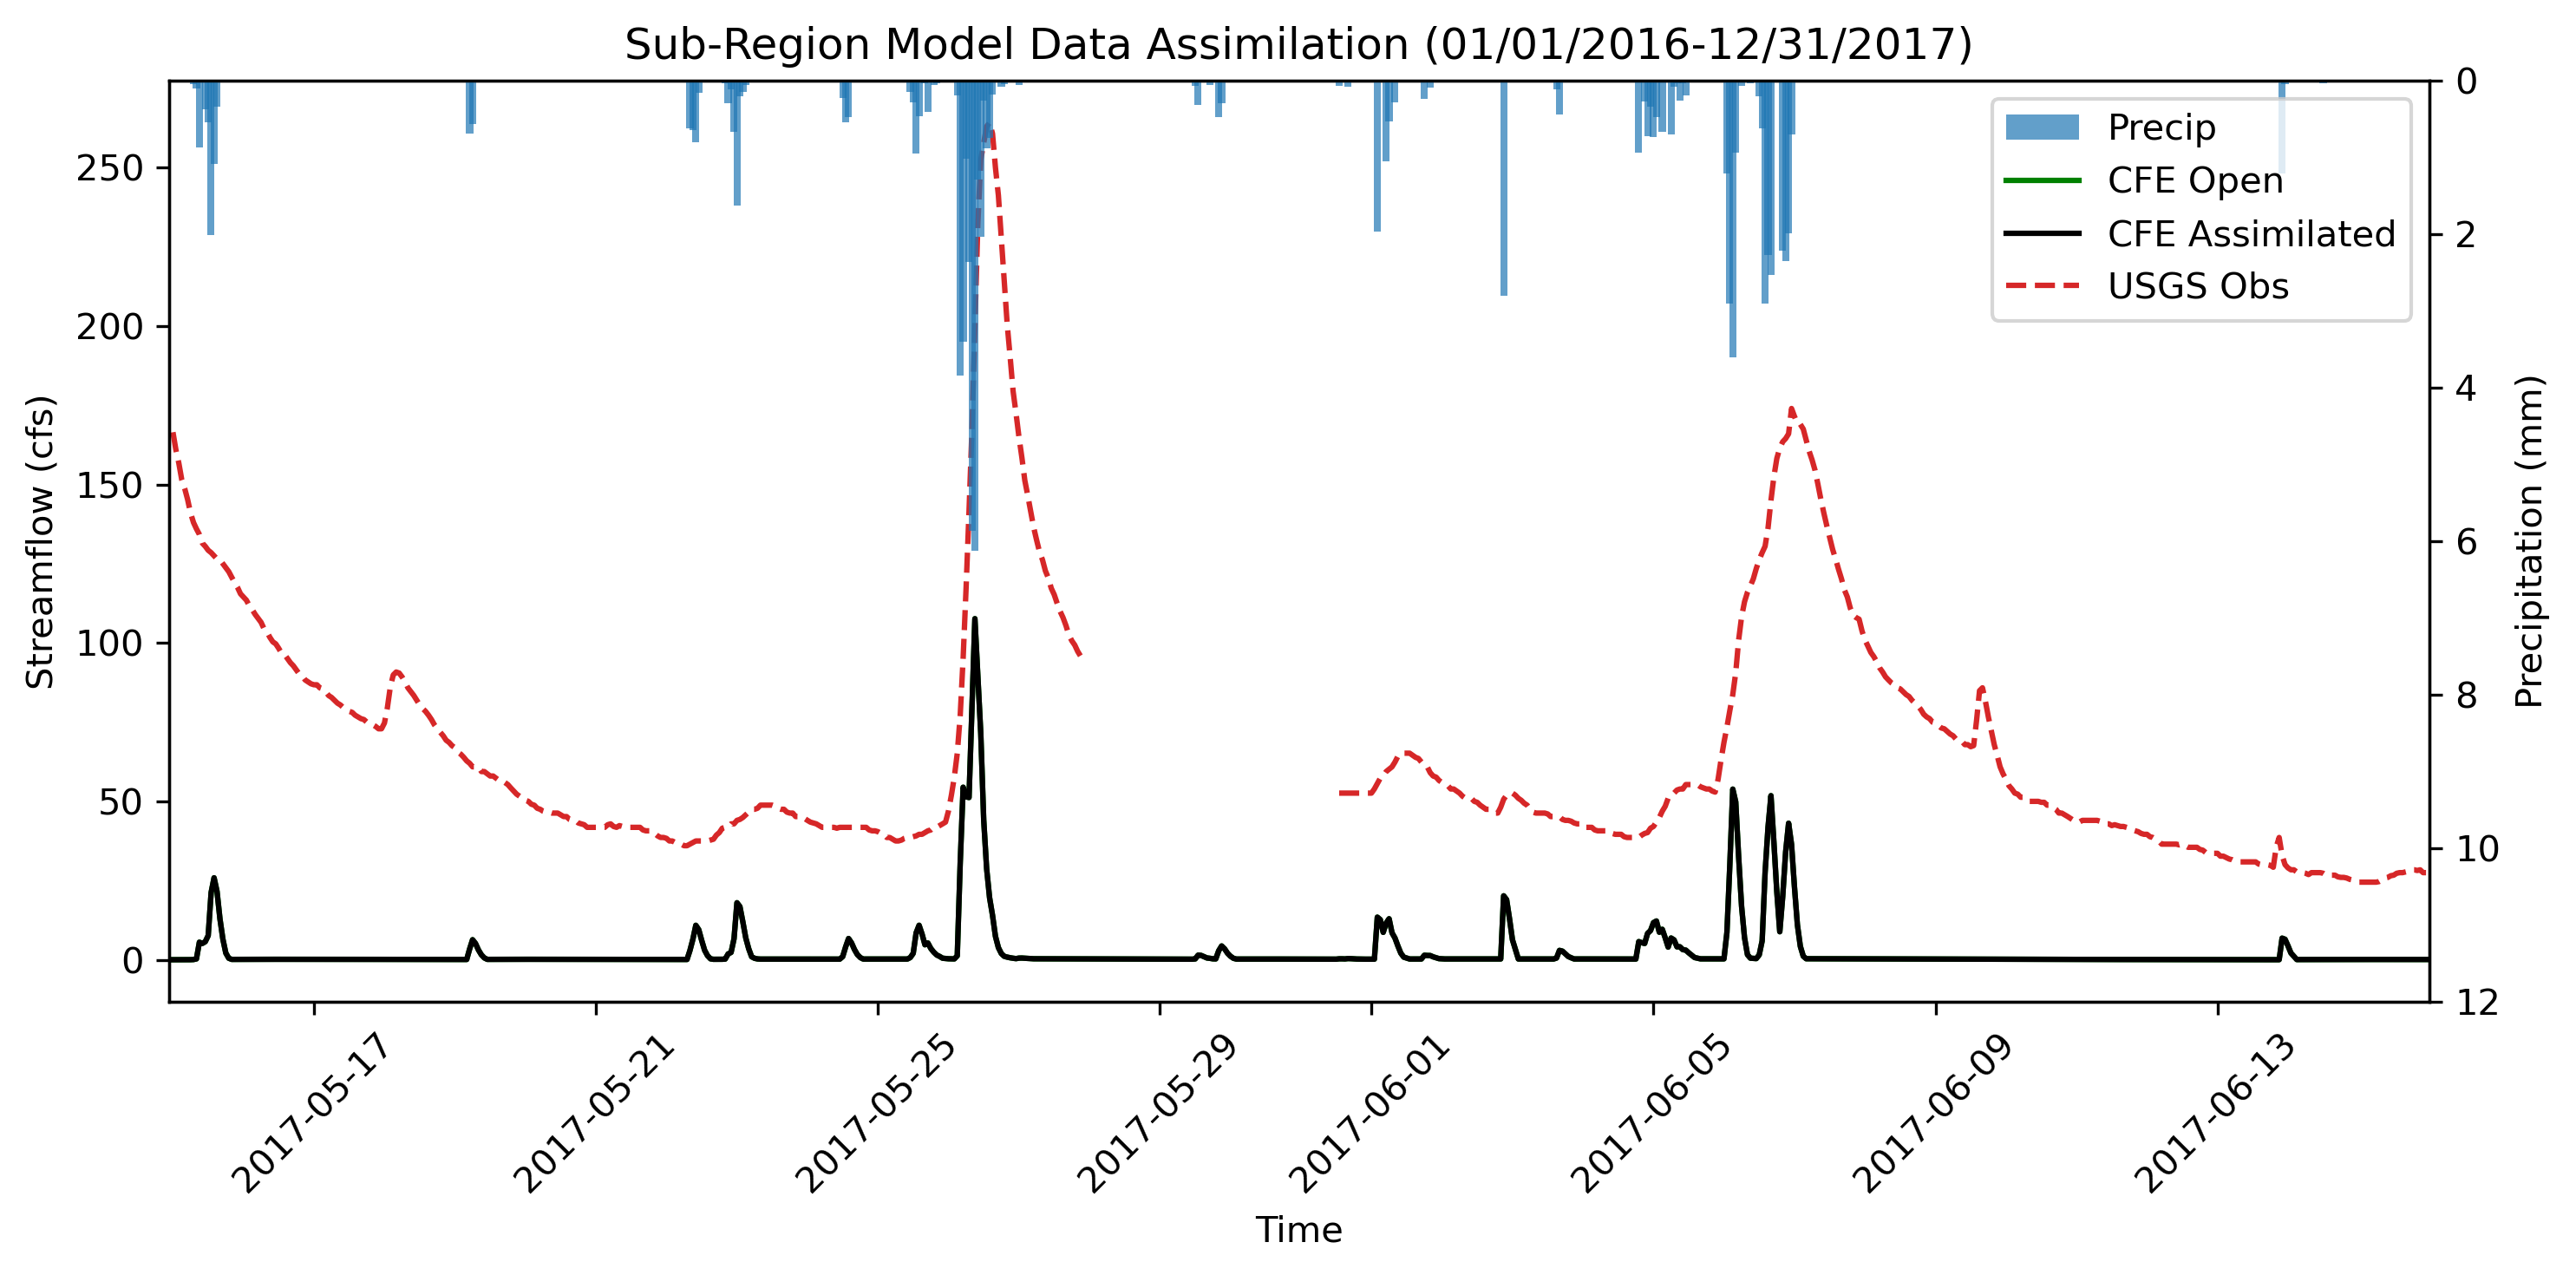

In [6]:
# Define time range for plotting
istart_plot=0
iend_plot=720
x = list(range(istart_plot, iend_plot))

# Get Date out of forcing file for plotting on x-axis
Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

# Set plotting dimensions
fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

# Make double y-axis to plot precipitation on top of of the plot. Set labels and limits for axes
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()

ax1.set_xlabel('Time')
ax1.tick_params(axis='x', labelrotation = 45)
#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
ax1.set_ylabel('Streamflow (cfs)')

plt.title('Sub-Region Model Data Assimilation (01/01/2016-12/31/2017)')
#plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')

# Plot the variables on the plot! 
Precip = ax2.bar(df_forcing['time'], df_forcing['APCP_surface'],width=0.1,alpha=0.7, color="tab:blue", label = 'Precip')
Open, = ax1.plot(df_forcing['time'], cfeOpen, color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(df_forcing['time'], cfeAnalysis, color = 'black', label = 'CFE Assimilated')
Obs, = ax1.plot(df_forcing['time'], obs, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

# Plot the legend and fix layout
plt.legend(handles = [Precip,Open,Analysis,Obs], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
fig.tight_layout()
ax1.margins(x=0)

#plt.savefig("SubRegionModel.png")
plt.show()


Get statistics to see the improvement of CFE Analysis

In [7]:
# Put values into dataframe to calculate statistics
df = pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True) #drop NaN values
df.reset_index(drop=True, inplace=True) #reset index

# CFE Open Evaluation
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("CFE Open Statistics")
print("r_open     =",r_open[0])
print("KGE_open   =",kge_open[0])
print("NSE_open   =", nse_open[0])
print("PBIAS_open =", pbias_open[0])
print("--------------------------")

# CFE Analysis Evaluation
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("CFE Analysis Statistics")
print("r_analysis     =",r_analysis[0])
print("KGE_analysis   =",kge_analysis[0])
print("NSE_analysis   =", nse_analysis[0])
print("PBIAS_analysis =", pbias_analysis[0])
print("--------------------------")

# Mean and Std of Models and Observations
print("Mean and STD of Models and Observations")
print("mean_obs      =",np.mean(df["obs"]))
print("STD_obs       =",np.std(df["obs"]))
print("mean_open     =",np.mean(df["cfeOpen"]))
print("STD_open      =",np.std(df["cfeOpen"]))
print("mean_analysis =",np.mean(df["cfeAnalysis"]))
print("STD_analysis  =",np.std(df["cfeAnalysis"]))

CFE Open Statistics
r_open     = 0.41925141584600917
KGE_open   = -23.001441754847335
NSE_open   = -60.30734886122457
PBIAS_open = -2377.2037194320797
--------------------------
CFE Analysis Statistics
r_analysis     = 0.41925141584600917
KGE_analysis   = -23.001441754847335
NSE_analysis   = -60.30734886122457
PBIAS_analysis = -2377.2037194320797
--------------------------
Mean and STD of Models and Observations
mean_obs      = 66.93546270718221
STD_obs       = 40.45261101684418
mean_open     = 2.7020572503632385
STD_open      = 9.497769973505365
mean_analysis = 2.7020572503632385
STD_analysis  = 9.497769973505365
